<a href="https://colab.research.google.com/github/Rickkk2/DataAugmentation/blob/main/Technical_exercise_Data_scientist_intern_Giskard.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Original model**

In [ ]:
# Install the Giskard library
#!pip install giskard

In [ ]:
# Connect to the external ML worker in daemon mode
#!giskard worker start -d


In [75]:
# Required dependencies
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt

from sklearn import model_selection
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

from ctgan import CTGAN
from sdv.single_table import CTGANSynthesizer
from sdv.single_table import GaussianCopulaSynthesizer
from sdv.single_table import TVAESynthesizer
from sdv.single_table import CopulaGANSynthesizer
from sdv.metadata import SingleTableMetadata
from sdv.evaluation.single_table import evaluate_quality
from sdv.evaluation.single_table import run_diagnostic
from sdv.evaluation.single_table import get_column_plot
from sdv.sampling import Condition

In [ ]:
# Read dataset and open as dataframe
url = 'https://raw.githubusercontent.com/Giskard-AI/giskard-client/main/sample_data/classification/credit/german_credit_prepared.csv'
credit = pd.read_csv(url, sep=',',engine="python")
credit.info()

In [ ]:
# See the domain and distribution of each column
for column in credit:
  print("------------------------------\n", credit[column].value_counts(), sep ='')

In [78]:
# Declare the type of each column in the dataset(example: category, numeric, text)
column_types = {'default':"category",
               'account_check_status':"category", 
               'duration_in_month':"numeric",
               'credit_history':"category",
               'purpose':"category",
               'credit_amount':"numeric",
               'savings':"category",
               'present_emp_since':"category",
               'installment_as_income_perc':"numeric",
               'sex':"category",
               'personal_status':"category",
               'other_debtors':"category",
               'present_res_since':"numeric",
               'property':"category",
               'age':"numeric",
               'other_installment_plans':"category",
               'housing':"category",
               'credits_this_bank':"numeric",
               'job':"category",
               'people_under_maintenance':"numeric",
               'telephone':"category",
               'foreign_worker':"category"}

In [79]:
# feature_types is used to declare the features the model is trained on
feature_types = {i:column_types[i] for i in column_types if i!='default'}

# Pipeline to fill missing values, transform and scale the numeric columns
columns_to_scale = [key for key in feature_types.keys() if feature_types[key]=="numeric"]
numeric_transformer = Pipeline([('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

# Pipeline to fill missing values and one hot encode the categorical values
columns_to_encode = [key for key in feature_types.keys() if feature_types[key]=="category"]
categorical_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', OneHotEncoder(handle_unknown='ignore',sparse_output=False)) ])

# Perform preprocessing of the columns with the above pipelines
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, columns_to_scale),
      ('cat', categorical_transformer, columns_to_encode)
          ]
)

# Pipeline for the model Logistic Regression
clf_logistic_regression = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LogisticRegression(max_iter =1000))])

# Split the data into train and test
Y = credit['default']
X = credit.drop(columns="default")
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y, test_size=0.20,random_state = 30, stratify = Y)

In [80]:
# Train the Logistic Regression model and get the mean accuracy on the given test data and labels
clf_logistic_regression.fit(X_train, Y_train)
clf_logistic_regression.score(X_test, Y_test)

0.785

0.785 is a good result for accuracy. However, let's try to improve it by applying data augmentation techniques on the training set.

In [81]:
# Our real dataset
train_data = pd.concat([Y_train, X_train], axis=1, join='inner')

# **Data Augmentation**

In [ ]:
# We will use the Synthetic Data Vault (SDV) library to create tabular synthetic data
!pip install sdv

## GaussianCopulaSynthesizer

In [83]:
metadata = SingleTableMetadata()
metadata.detect_from_dataframe(data=train_data)

In [84]:
synthesizer1 = GaussianCopulaSynthesizer(metadata)
synthesizer1.fit(train_data)

In [ ]:
synthesizer1.reset_sampling()
synthetic_data1 = synthesizer1.sample(num_rows=250)
for column in synthetic_data1:
  print("------------------------------\n", synthetic_data1[column].value_counts(), sep ='')

In [86]:
Y_train_aug1 = synthetic_data1['default']
X_train_aug1 = synthetic_data1.drop(columns="default")

clf_logistic_regression.fit(pd.concat([X_train, X_train_aug1]), pd.concat([Y_train, Y_train_aug1]))
clf_logistic_regression.score(X_test, Y_test)

0.76

0.76 is still a good result for accuracy, but worse than that obtained without data augmentation



In [87]:
quality_report1 = evaluate_quality(
    real_data=train_data,
    synthetic_data=synthetic_data1,
    metadata=metadata)

Creating report: 100%|██████████| 4/4 [00:04<00:00,  1.09s/it]



Overall Quality Score: 78.55%

Properties:
Column Shapes: 82.82%
Column Pair Trends: 74.28%


In [88]:
diagnostic_report1 = run_diagnostic(
    real_data=train_data,
    synthetic_data=synthetic_data1,
    metadata=metadata)

Creating report: 100%|██████████| 4/4 [00:14<00:00,  3.69s/it]


DiagnosticResults:

SUCCESS:
✓ The synthetic data covers over 90% of the numerical ranges present in the real data
✓ The synthetic data covers over 90% of the categories present in the real data
✓ Over 90% of the synthetic rows are not copies of the real data
✓ The synthetic data follows over 90% of the min/max boundaries set by the real data


In [89]:
fig1 = get_column_plot(
    real_data=train_data,
    synthetic_data=synthetic_data1,
    column_name='credit_history',
    metadata=metadata
)
    
fig1.show()

## CTGANSynthesizer

In [90]:
synthesizer2 = CTGANSynthesizer(metadata)
synthesizer2.fit(train_data)

In [ ]:
synthesizer2.reset_sampling()
synthetic_data2 = synthesizer2.sample(num_rows=250)
for column in synthetic_data2:
  print("------------------------------\n", synthetic_data2[column].value_counts(), sep ='')

In [92]:
Y_train_aug2 = synthetic_data2['default']
X_train_aug2 = synthetic_data2.drop(columns="default")

clf_logistic_regression.fit(pd.concat([X_train, X_train_aug2]), pd.concat([Y_train, Y_train_aug2]))
clf_logistic_regression.score(X_test, Y_test)

0.795

0.795 improves on original accuracy

In [93]:
quality_report2 = evaluate_quality(
    real_data=train_data,
    synthetic_data=synthetic_data2,
    metadata=metadata)

Creating report: 100%|██████████| 4/4 [00:02<00:00,  1.90it/s]



Overall Quality Score: 87.99%

Properties:
Column Shapes: 91.2%
Column Pair Trends: 84.79%


In [94]:
diagnostic_report2 = run_diagnostic(
    real_data=train_data,
    synthetic_data=synthetic_data2,
    metadata=metadata)

Creating report: 100%|██████████| 4/4 [00:06<00:00,  1.61s/it]


DiagnosticResults:

SUCCESS:
✓ The synthetic data covers over 90% of the numerical ranges present in the real data
✓ The synthetic data covers over 90% of the categories present in the real data
✓ Over 90% of the synthetic rows are not copies of the real data
✓ The synthetic data follows over 90% of the min/max boundaries set by the real data


In [95]:
fig2 = get_column_plot(
    real_data=train_data,
    synthetic_data=synthetic_data2,
    column_name='credit_history',
    metadata=metadata
)

fig2.show()

## TVAESynthesizer


In [96]:
synthesizer3 = TVAESynthesizer(metadata)
synthesizer3.fit(train_data)

In [ ]:
synthesizer3.reset_sampling()
synthetic_data3 = synthesizer3.sample(num_rows=250)
for column in synthetic_data3:
  print("------------------------------\n", synthetic_data3[column].value_counts(), sep ='')

In [98]:
Y_train_aug3 = synthetic_data3['default']
X_train_aug3 = synthetic_data3.drop(columns="default")

clf_logistic_regression.fit(pd.concat([X_train, X_train_aug3]), pd.concat([Y_train, Y_train_aug3]))
clf_logistic_regression.score(X_test, Y_test)

0.765

0.765 doesn't improve

In [99]:
quality_report3 = evaluate_quality(
    real_data=train_data,
    synthetic_data=synthetic_data3,
    metadata=metadata)

Creating report: 100%|██████████| 4/4 [00:02<00:00,  1.38it/s]



Overall Quality Score: 73.26%

Properties:
Column Shapes: 78.71%
Column Pair Trends: 67.82%


In [100]:
diagnostic_report3 = run_diagnostic(
    real_data=train_data,
    synthetic_data=synthetic_data3,
    metadata=metadata)

Creating report: 100%|██████████| 4/4 [00:06<00:00,  1.58s/it]


DiagnosticResults:

SUCCESS:
✓ Over 90% of the synthetic rows are not copies of the real data
✓ The synthetic data follows over 90% of the min/max boundaries set by the real data

! The synthetic data is missing more than 10% of the numerical ranges present in the real data
! The synthetic data is missing more than 10% of the categories present in the real data


In [101]:
fig3 = get_column_plot(
    real_data=train_data,
    synthetic_data=synthetic_data3,
    column_name='credit_history',
    metadata=metadata
)

fig3.show()

## CopulaGANSynthesizer

In [ ]:
synthesizer4 = CopulaGANSynthesizer(metadata)
synthesizer4.fit(train_data)

In [ ]:
synthesizer4.reset_sampling()
synthetic_data4 = synthesizer4.sample(num_rows=250)
for column in synthetic_data4:
  print("------------------------------\n", synthetic_data4[column].value_counts(), sep ='')

In [ ]:
Y_train_aug4 = synthetic_data4['default']
X_train_aug4 = synthetic_data4.drop(columns="default")

clf_logistic_regression.fit(pd.concat([X_train, X_train_aug4]), pd.concat([Y_train, Y_train_aug4]))
clf_logistic_regression.score(X_test, Y_test)

0.765

0.765 doesn't improve

In [ ]:
quality_report4 = evaluate_quality(
    real_data=train_data,
    synthetic_data=synthetic_data4,
    metadata=metadata)

Creating report: 100%|██████████| 4/4 [00:02<00:00,  1.89it/s]



Overall Quality Score: 84.23%

Properties:
Column Shapes: 87.19%
Column Pair Trends: 81.27%


In [ ]:
diagnostic_report4 = run_diagnostic(
    real_data=train_data,
    synthetic_data=synthetic_data4,
    metadata=metadata)

Creating report: 100%|██████████| 4/4 [00:06<00:00,  1.67s/it]


DiagnosticResults:

SUCCESS:
✓ The synthetic data covers over 90% of the numerical ranges present in the real data
✓ The synthetic data covers over 90% of the categories present in the real data
✓ Over 90% of the synthetic rows are not copies of the real data
✓ The synthetic data follows over 90% of the min/max boundaries set by the real data


In [ ]:
fig4 = get_column_plot(
    real_data=train_data,
    synthetic_data=synthetic_data4,
    column_name='credit_history',
    metadata=metadata
)

fig4.show()

# **Improvement and Conclusions**

Apparently, CTGANSynthesizer is the best model for this scenario. When doing data augmentation on a tabular dataset, a balance must be achieved in adding rows to avoid underfitting and overfitting. 

In [104]:
def res(x):
  synthesizer2.reset_sampling()
  synthetic_data = synthesizer2.sample(num_rows=x)

  Y_train_aug = synthetic_data['default']
  X_train_aug = synthetic_data.drop(columns="default")

  clf_logistic_regression.fit(pd.concat([X_train, X_train_aug]), pd.concat([Y_train, Y_train_aug]))
  return clf_logistic_regression.score(X_test, Y_test)

In [105]:
x = list(range(1,5000))
y = []

for id, i in enumerate(x):
  y.append(res(x[id]))

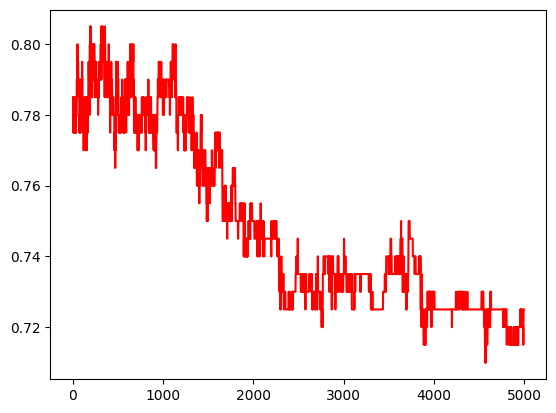

In [106]:
plt.plot(x, y, color='red')

plt.show()

In [107]:
maximum_val= y[0]
for i in range(1, len(y)): 
    if (y[i] > maximum_val):
        maximum_val = y[i]
print("Maximum Index position: ",y.index(maximum_val))

Maximum Index position:  189


In [108]:
x_max = list(range(150,500))
y_max = []

for id, i in enumerate(x_max):
  y_max.append(res(x[id]))

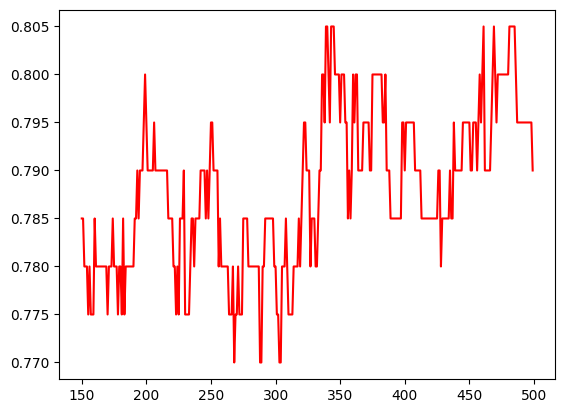

In [109]:
plt.plot(x_max, y_max, color='red')

plt.show()

We can observe several peaks that reach or exceed 0.8 to 0.805, which is an interesting improvement in accuracy.

As we have calculated above, the first time the maximum value is reached is with 190 new rows.

In [111]:
res(190)

0.805

We have managed to improve from 0.785 to 0.805 using the GAN-based synthesizer. Perhaps we could improve this result even further.